# RANS Airfoil Flows with Ensambles Neural Nets

## Overview

We are now considering the same setup as in the notebook {doc}`supervised-airfoils`: A turbulent airflow around wing profiles, for which we'd like to know the average motion
and pressure distribution around this airfoil for different Reynolds numbers and angles of attack. In the earlier notebook, we tackled this by completely bypassing any physical solver and instead training a neural network that learns the quantities of interest.  In contrast to traditional networks, that learn a single point estimate for each weight value, uncertainty estimation aim at learning a _distribution_ . Ensembles \cite{ensembles} aggregate outputs from several models trained independently on identical data. These models arise from Hyper-Parameter Optimization (HPO), thus negating extra computational time. By aggregating the $M$ best models, we yield optimal hyperparameters and uncertainty estimations. With input $x$ and label $y$, a neural network (NN) predicts the distribution $p_\theta(y \mid x)$ where $\theta$ represents the NN's parameters. We harness an ensemble of $M$ models and their hyperparameters, $(\theta_m)_{m=1}^M$, training them in parallel on the same dataset. The combined prediction is:
$p(y\mid x)=M^{-1}\sum_{m=1}^M{p_{\theta_m}(y \mid x,\theta_m)}$. Uncertainties are calculated from the standard deviation of predicted probabilities across the ensemble.

ensamble article: Florian Wenzel and Jasper Snoek and Dustin Tran and Rodolphe Jenatton,"Hyperparameter Ensembles for Robustness and Uncertainty Quantification", 2020, Eprint = arXiv:2006.13570


In [ ]:
#!pip install tensorflow==2.16.1


### Read in Data
Like in the previous notebook we'll skip the data generation process. This example is adapted from [the Deep-Flow-Prediction codebase](https://github.com/thunil/Deep-Flow-Prediction), which you can check out for details. Here, we'll simply download a small set of training data generated with a Spalart-Almaras RANS simulation in [OpenFOAM](https://openfoam.org/).

In [ ]:
import numpy as np
import os.path, random

# get training data: as in the previous supervised example, either download or use gdrive
dir = "./"
if False:
    if not os.path.isfile('data-airfoils.npz'):
        import requests
        print("Downloading training data (300MB), this can take a few minutes the first time...")
        with open("data-airfoils.npz", 'wb') as datafile:
            resp = requests.get('https://dataserv.ub.tum.de/s/m1615239/download?path=%2F&files=dfp-data-400.npz', verify=False)
            datafile.write(resp.content)
else: # cf supervised airfoil code:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/"

npfile=np.load(dir+'data-airfoils.npz')
print("Loaded data, {} training, {} validation samples".format(len(npfile["inputs"]),len(npfile["vinputs"])))
print("Size of the inputs array: "+format(npfile["inputs"].shape))

# reshape to channels_last for convencience
X_train = np.moveaxis(npfile["inputs"],1,-1)
y_train = np.moveaxis(npfile["targets"],1,-1)

X_val = np.moveaxis(npfile["vinputs"],1,-1)
y_val = np.moveaxis(npfile["vtargets"],1,-1)

Mounted at /content/gdrive
Loaded data, 320 training, 80 validation samples
Size of the inputs array: (320, 3, 128, 128)


### Look at Data
Now we have some training data. We can look at it using the code we also used in the original notebook:


Here are all 3 inputs are shown at the top (mask,in x, in y) 
Side by side with the 3 output channels (p,vx,vy) at the bottom:


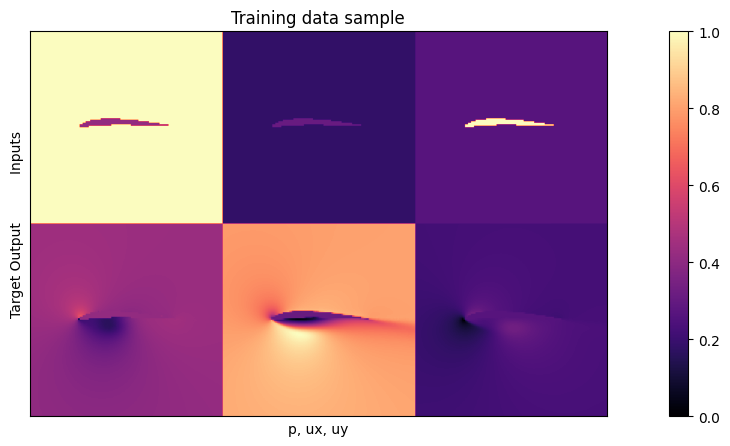

In [ ]:
import pylab
from matplotlib import cm

# helper to show three target channels: normalized, with colormap, side by side
def showSbs(a1,a2, bottom="NN Output", top="Reference", title=None):
  c=[]
  for i in range(3):
    b = np.flipud( np.concatenate((a2[...,i],a1[...,i]),axis=1).transpose())
    min, mean, max = np.min(b), np.mean(b), np.max(b);
    b -= min; b /= (max-min)
    c.append(b)
  fig, axes = pylab.subplots(1, 1, figsize=(16, 5))
  axes.set_xticks([]); axes.set_yticks([]);
  im = axes.imshow(np.concatenate(c,axis=1), origin='upper', cmap='magma')

  pylab.colorbar(im); pylab.xlabel('p, ux, uy'); pylab.ylabel('%s           %s'%(bottom,top))
  if title is not None: pylab.title(title)

NUM=300
print("\nHere are all 3 inputs are shown at the top (mask,in x, in y) \nSide by side with the 3 output channels (p,vx,vy) at the bottom:")
showSbs( X_train[NUM],y_train[NUM], bottom="Target Output", top="Inputs", title="Training data sample")


Not surprisingly, the data still looks the same. For details, please check out the description in {doc}`supervised-airfoils`.

### Neural Network Definition
Now let's look at how we can implement Ensamble. Instead of PyTorch, we will use TensorFlow, in particular the extension TensorFlow Probability, which has easy-to-implement probabilistic layers. Like in the other notebook, we use a U-Net structure consisting of Convolutional blocks with skip-layer connections. For now, we only want to set up the decoder, i.e. second part of the U-Net as bayesian. For this, we will take advantage of TensorFlows _flipout_ layers (in particular, the convolutional implementation).

In a forward pass, those layers automatically sample from the current posterior distribution and store the KL-divergence between prior and posterior in _model.losses_. One can specify the desired divergence measure (typically KL-divergence) and modify the prior and approximate posterior distributions, if other than normal distributions are desired. Other than that, the flipout layers can be used just like regular layers in sequential architectures. The code below implements a single convolutional block of the U-Net:

In [ ]:
import tensorflow as tf
#import tensorflow_probability.python.distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose,UpSampling2D, BatchNormalization, ReLU, LeakyReLU, SpatialDropout2D, MaxPooling2D
#from tensorflow_probability.python.layers import Convolution2DFlipout
from tensorflow.keras.models import Model


def tfBlockUnet(filters=3, transposed=False, kernel_size=4, bn=True, relu=True, pad="same", dropout=0., flipout=False,
              kdf=None, name=''):
    block = Sequential(name=name)
    if relu:
        block.add(ReLU())
    else:
        block.add(LeakyReLU(0.2))
    if not transposed:
        block.add(Conv2D(filters=filters, kernel_size=kernel_size, padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), activation=None,strides=(2,2)))
    else:
        block.add(UpSampling2D(interpolation = 'bilinear'))
        #if flipout:
        #    block.add(Convolution2DFlipout(filters=filters, kernel_size=(kernel_size-1), strides=(1, 1), padding=pad,
        #                                   data_format="channels_last", kernel_divergence_fn=kdf,
        #                                   activation=None))
        #else:
        block.add(Conv2D(filters=filters, kernel_size=(kernel_size-1), padding=pad,
                         kernel_initializer=RandomNormal(0.0, 0.02), strides=(1,1), activation=None))

    block.add(SpatialDropout2D(rate=dropout))

    if bn:
        block.add(BatchNormalization(axis=-1, epsilon=1e-05,momentum=0.9))

    return block

Next we define the full network with these blocks

In [ ]:
from tensorflow.keras.layers import Concatenate

def Bayes_DfpNet(input_shape=(128,128,3),expo=5,dropout=0.):
    channels = int(2 ** expo + 0.5)

    layer1=Sequential(name='layer1')
    layer1.add(Conv2D(filters=channels,kernel_size=4,strides=(2,2),padding='same',activation=None,data_format='channels_last'))
    layer2=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer2')
    layer3=tfBlockUnet(filters=channels*2,transposed=False,bn=True, relu=False,dropout=dropout,name='layer3')
    layer4=tfBlockUnet(filters=channels*4,transposed=False,bn=True, relu=False,dropout=dropout,name='layer4')
    layer5=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,name='layer5')
    layer6=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer6')
    layer7=tfBlockUnet(filters=channels*8,transposed=False,bn=True, relu=False,dropout=dropout,kernel_size=2,pad='valid',name='layer7')

    # note, kernel size is internally reduced by one for the decoder part
    dlayer7=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, kernel_size=2,pad='valid',name='dlayer7')
    dlayer6=tfBlockUnet(filters=channels*8,transposed=True,bn=True, relu=True,dropout=dropout, kernel_size=2,pad='valid',name='dlayer6')
    dlayer5=tfBlockUnet(filters=channels*4,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer5')
    dlayer4=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer4')
    dlayer3=tfBlockUnet(filters=channels*2,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer3')
    dlayer2=tfBlockUnet(filters=channels  ,transposed=True,bn=True, relu=True,dropout=dropout,name='dlayer2')
    dlayer1=Sequential(name='outlayer')
    dlayer1.add(ReLU())
    dlayer1.add(Conv2DTranspose(3,kernel_size=4,strides=(2,2),padding='same'))

    # forward pass
    inputs=Input(input_shape)
    out1 = layer1(inputs)
    out2 = layer2(out1)
    out3 = layer3(out2)
    out4 = layer4(out3)
    out5 = layer5(out4)
    out6 = layer6(out5)
    out7 = layer7(out6)
    # ... bottleneck ...
    dout6 = dlayer7(out7)
    #dout6_out6 = tf.concat([dout6,out6],axis=3)
    #dout6 = dlayer6(dout6_out6)
    #dout6_out5 = tf.concat([dout6, out5], axis=3)
    #dout5 = dlayer5(dout6_out5)
    #dout5_out4 = tf.concat([dout5, out4], axis=3)
    #dout4 = dlayer4(dout5_out4)
    #dout4_out3 = tf.concat([dout4, out3], axis=3)
    #dout3 = dlayer3(dout4_out3)
    #dout3_out2 = tf.concat([dout3, out2], axis=3)
    #dout2 = dlayer2(dout3_out2)
    #dout2_out1 = tf.concat([dout2, out1], axis=3)
    #dout1 = dlayer1(dout2_out1)
    dout6_out6 = Concatenate(axis=3)([dout6,out6])
    dout6 = dlayer6(dout6_out6)
    dout6_out5 = Concatenate(axis=3)([dout6, out5])
    dout5 = dlayer5(dout6_out5)
    dout5_out4 = Concatenate(axis=3)([dout5, out4])
    dout4 = dlayer4(dout5_out4)
    dout4_out3 = Concatenate(axis=3)([dout4, out3])
    dout3 = dlayer3(dout4_out3)
    dout3_out2 = Concatenate(axis=3)([dout3, out2])
    dout2 = dlayer2(dout3_out2)
    dout2_out1 = Concatenate(axis=3)([dout2, out1])
    dout1 = dlayer1(dout2_out1)

    return Model(inputs=inputs,outputs=dout1)



Let's define the hyperparameters and create a tensorflow dataset to organize inputs and targets. Since we have 320 observations in the training set, for a batch-size of 10

In [ ]:
import math
import matplotlib.pyplot as plt

BATCH_SIZE=200
LR=0.01
EPOCHS = 150
#KL_PREF = 5000

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train),
    seed=46168531, reshuffle_each_iteration=False).batch(BATCH_SIZE, drop_remainder=False)



Let's initialize the network. Here we're finally computing the `kl_scaling` factor via `KL_PREF` and the batch size.

In [ ]:
from tensorflow.keras.optimizers import RMSprop, Adam


model=Bayes_DfpNet(expo=4)
optimizer = Adam(learning_rate=LR, beta_1=0.5,beta_2=0.9999)

#num_params = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
#print('The U-Net has {} parameters.'.format(num_params))
num_params = np.sum([np.prod(v.shape) for v in model.trainable_variables])
print('The U-Net has {} parameters.'.format(num_params))

The U-Net has 585667 parameters.


In [ ]:
from tensorflow.keras.losses import mae
import math
import time
mae_losses=[]
total_losses=[]
mae_losses_vali=[]
start = time.time()
for epoch in range(EPOCHS):
    currLr=LR
    #tf.keras.backend.set_value(optimizer.learning_rate, currLr)
    # iterate through training data
    mae_sum = 0
    total_sum=0
    for i, traindata in enumerate(dataset, 0):
      # forward pass and loss computation
        with tf.GradientTape() as tape:
            inputs, targets = traindata
            prediction = model(inputs, training=True)
            loss_mae = tf.reduce_mean(mae(prediction, targets))
            loss_value=tf.cast(loss_mae, dtype='float32')
        # backpropagate gradients and update parameters
        gradients = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # store losses per batch
        mae_sum += tf.reduce_mean(loss_mae)
        total_sum+=tf.reduce_mean(loss_value)

    # store losses per epoch
    mae_losses+=[mae_sum/len(dataset)]
    total_losses+=[total_sum/len(dataset)]

    # validation
    outputs = model.predict(X_val)
    mae_losses_vali += [tf.reduce_mean(mae(y_val, outputs))]

    if epoch<3 or epoch%20==0:
        print('Epoch {}/{}, total loss: {:.3f}, MAE loss: {:.4f}, MAE loss vali: {:.4f}'.format(epoch, EPOCHS, total_losses[-1], mae_losses[-1], mae_losses_vali[-1]))
end = time.time()
print(end - start)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Epoch 0/150, total loss: 0.254, MAE loss: 0.2539, MAE loss vali: 1.7215
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Epoch 1/150, total loss: 0.136, MAE loss: 0.1364, MAE loss vali: 0.5810
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Epoch 2/150, total loss: 0.088, MAE loss: 0.0882, MAE loss vali: 0.1656
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [ ]:
#save the model
path_model = "./"
path_model="/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/TF/"
model.save(path_model+'network-150-LR0.01.h5')

 trained! Let's look at the loss. Since the loss consists of two separate parts, it is helpful to monitor both parts (MAE and KL).

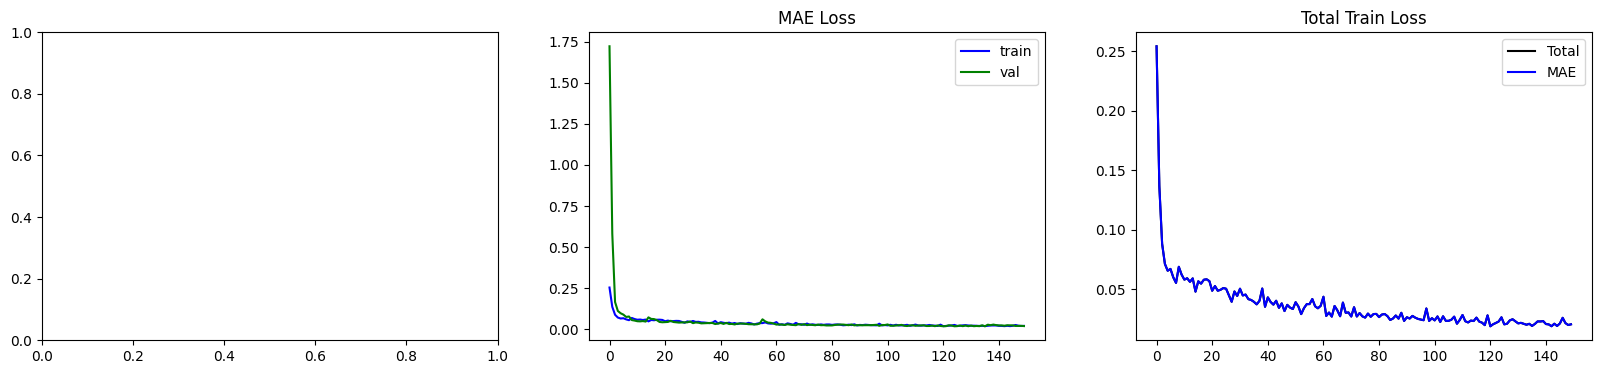

In [ ]:
fig,axs=plt.subplots(ncols=3,nrows=1,figsize=(20,4))

#axs[0].plot(kl_losses,color='red')
#axs[0].set_title('KL Loss (Train)')
axs[1].plot(mae_losses,color='blue',label='train')
axs[1].plot(mae_losses_vali,color='green',label='val')
axs[1].set_title('MAE Loss'); axs[1].legend()

axs[2].plot(total_losses,label='Total',color='black')
#axs[2].plot(kl_losses,label='KL',color='red')
axs[2].plot(mae_losses,label='MAE',color='blue')
axs[2].set_title('Total Train Loss'); axs[2].legend()

[CHECK THIS This way, we can double-check if minimizing one part of the loss comes at the cost of increasing the other. For our case, we observe that both parts decrease smoothly. In particular, the MAE loss is not increasing for the validation set, indicating that we are not overfitting].



In [ ]:
# there should be 6 entries in model.losses since we have 6 blocks with flipout layers in our model
print('There are {} entries in model.losses'.format(len(model.losses)))
print(model.losses)

There are 0 entries in model.losses
[]


In [ ]:
from keras.models import load_model

Now let's visualize how the Ensambles  performs for unseen data from the validation set. ADD here enssamble introduction from our paper

In [ ]:
#ENSAMBLE LEARNING:
#load the saved models from the google drive
#Note: all previous cells are to run just
# load the model
path_model="/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/TF/"
dir_list = os.listdir(path_model)

#Valuation Predictions in the entire test set
mc_predictions = []
REPS=len(dir_list) # should be the length of the folder with the different models
preds=np.zeros(shape=(REPS,)+X_val.shape)
rep=0
for x in dir_list:
  #if x.endswith('.keras'):
  if x.endswith('.h5'):
    # load model
    model = load_model(path_model+x, compile=False)
    # predict digit
    #y_p = model.predict(X_val, batch_size=1)
    #mc_predictions.append(y_p)
    preds[rep,:,:,:,:]=model.predict(X_val)
    rep+=1
preds_mean=np.mean(preds,axis=0)
preds_std=np.std(preds,axis=0)
#end = time.time()
#print(end - start)


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step
1/3 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 656ms/step


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 648ms/step


Before inspecting the mean and standard deviation computed in the previous cell, let's visualize one of the outputs of the BNN. In the following plot, the input is shown in the first row, while the second row illustrates the result of a single forward pass.


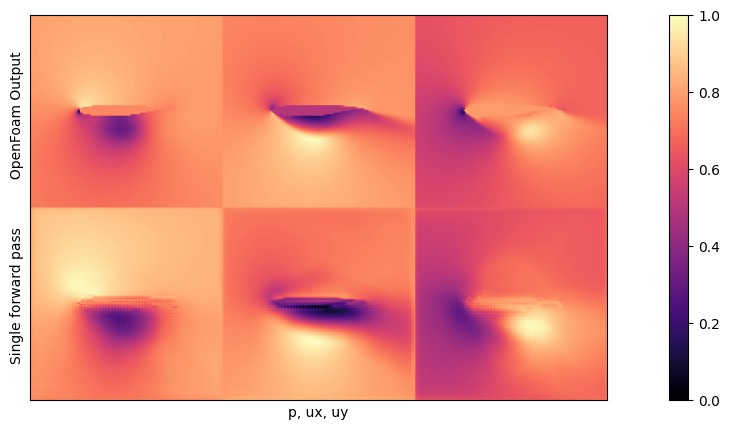

In [ ]:
NUM=16
# show a single prediction
showSbs(y_val[NUM],preds[0][NUM], top="OpenFoam Output", bottom="Single forward pass")


If you compare this image to one of the outputs from {doc}`supervised-airfoils`, you'll see that it doesn't look to different on first sight. This is a good sign, it seems the network learned to produce the content of the pressure and velocity fields.

More importantly, though, we can now visualize the uncertainty over predictions more clearly by inspecting several samples from the posterior distribution  as well as the standard deviation for a given input. Below is code for a function that visualizes precisely that (uncertainty is shown with a different colormap in order to illustrate the differences to previous non-bayesian notebook).

num_preds was set to 5, but has to be smaller than the length of preds. Setting it to 3


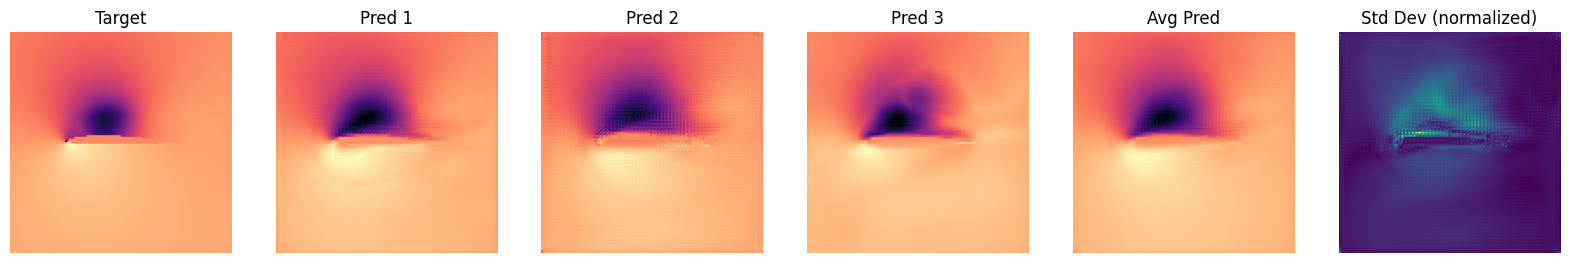

In [ ]:
# plot repeated samples from posterior for some observations
def plot_BNN_predictions(target, preds, pred_mean, pred_std, num_preds=5,channel=0):
  if num_preds>len(preds):
    print('num_preds was set to {}, but has to be smaller than the length of preds. Setting it to {}'.format(num_preds,len(preds)))
    num_preds = len(preds)

  # transpose and concatenate the frames that are to plot
  to_plot=np.concatenate((target[:,:,channel].transpose().reshape(128,128,1),preds[0:num_preds,:,:,channel].transpose(),
                          pred_mean[:,:,channel].transpose().reshape(128,128,1),pred_std[:,:,channel].transpose().reshape(128,128,1)),axis=-1)
  fig, axs = plt.subplots(nrows=1,ncols=to_plot.shape[-1],figsize=(20,4))
  for i in range(to_plot.shape[-1]):
    label='Target' if i==0 else ('Avg Pred' if i == (num_preds+1) else ('Std Dev (normalized)' if i == (num_preds+2) else 'Pred {}'.format(i)))
    colmap = cm.viridis if i==to_plot.shape[-1]-1 else cm.magma
    frame = np.flipud(to_plot[:,:,i])
    min=np.min(frame); max = np.max(frame)
    frame -= min; frame /=(max-min)
    axs[i].imshow(frame,cmap=colmap)
    axs[i].axis('off')
    axs[i].set_title(label)

OBS_IDX=5
plot_BNN_predictions(y_val[OBS_IDX,...],preds[:,OBS_IDX,:,:,:],preds_mean[OBS_IDX,...],preds_std[OBS_IDX,...])

We are looking at channel 0, i.e. the pressure here. One can observe that the dark and bright regions vary quite a bit across predictions. It is reassuring to note that - at least from visual inspection - the average (i.e. marginal) prediction is closer to the target than most of the single forward passes.

It should also be noted that each frame was normalized for the visualization. Therefore, when looking at the uncertainty frame, we can infer where the network is uncertain, but now how uncertain it is in absolute values.

In order to assess a global measure of uncertainty we can however compute an average standard deviation over all samples in the validation set.

In [ ]:
# Average Prediction with total uncertainty
uncertainty_total = np.mean(np.abs(preds_std),axis=(0,1,2))
preds_mean_global = np.mean(np.abs(preds),axis=(0,1,2,3))
print("\nAverage pixel prediction on validation set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_mean_global[0],3),np.round(uncertainty_total[0],3),np.round(preds_mean_global[1],3),np.round(uncertainty_total[1],3),np.round(preds_mean_global[2],3),np.round(uncertainty_total[2],3)))



Average pixel prediction on validation set: 
 pressure: 0.028 +- 0.008, 
 ux: 0.464 +- 0.017,
 uy: 0.079 +- 0.014


For a run with standard settings, the uncertainties are on the order of 0.01 for all three fields. As the pressure field has a smaller mean, it's uncertainty is larger in relative terms. This makes sense, as the pressure field is known to be more difficult to predict than the two velocity components.

## Test evaluation

Like in the case for a conventional neural network, let's now look at **proper** test samples, i.e. OOD samples, for which in this case we'll use new airfoil shapes. These are shapes that the network never saw in any training samples, and hence it tells us a bit about how well the network generalizes to new shapes.

As these samples are at least slightly OOD, we can draw conclusions about how well the network generalizes, which the validation data would not really tell us. In particular, we would like to investigate if the NN is more uncertain when handling OOD data. Like before, we first download the test samples ...

In [ ]:
dir = "./"
if False:
  if not os.path.isfile('data-airfoils-test.npz'):
    import urllib.request
    url="https://physicsbaseddeeplearning.org/data/data_test.npz"
    print("Downloading test data, this should be fast...")
    urllib.request.urlretrieve(url, 'data-airfoils-test.npz')
else: # cf supervised airfoil code:
    from google.colab import drive
    drive.mount('/content/gdrive')
    dir = "/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/"

nptfile=np.load(dir+'data-airfoils-test.npz')
print("Loaded {}/{} test samples".format(len(nptfile["test_inputs"]),len(nptfile["test_targets"])))


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Loaded 10/10 test samples


... and then repeat the procedure from above to evaluate the enssamble on the test samples, and compute the marginalized prediction and uncertainty.

In [ ]:
from tensorflow.keras.losses import mae

#load the saved models from the google drive
#start = time.time()
# load the model
path_model="/content/gdrive/MyDrive/ARGONNE/VFPArgonne24/ProjectsSYCLCode/AI-Code/RANS_ENSAMBLE_MODELS&DATA/TF/"
dir_list = os.listdir(path_model)

X_test = np.moveaxis(nptfile["test_inputs"],1,-1)
y_test = np.moveaxis(nptfile["test_targets"],1,-1)


REPS=10
REPS=len(dir_list) # should be the length of the folder with the different models
rep=0
preds_test=np.zeros(shape=(REPS,)+X_test.shape)
for x  in dir_list:
  if x.endswith('.keras'):
    # load model
    model = load_model(path_model+x)
    preds_test[rep,:,:,:,:]=model.predict(X_test)
    rep+=1
preds_test_mean=np.mean(preds_test,axis=0)
preds_test_std=np.std(preds_test,axis=0)
test_loss = tf.reduce_mean(mae(preds_test_mean, y_test))

print("\nAverage test error: {}".format(test_loss))


1/1 [==============================] - 0s 297ms/step

Average test error: 0.016964053949248475


In [ ]:
# Average Prediction with total uncertainty
uncertainty_test_total = np.mean(np.abs(preds_test_std),axis=(0,1,2))
preds_test_mean_global = np.mean(np.abs(preds_test),axis=(0,1,2,3))
print("\nAverage pixel prediction on test set: \n pressure: {} +- {}, \n ux: {} +- {},\n uy: {} +- {}".format(np.round(preds_test_mean_global[0],3),np.round(uncertainty_test_total[0],3),np.round(preds_test_mean_global[1],3),np.round(uncertainty_test_total[1],3),np.round(preds_test_mean_global[2],3),np.round(uncertainty_test_total[2],3)))



Average pixel prediction on test set: 
 pressure: 0.03 +- 0.01, 
 ux: 0.457 +- 0.021,
 uy: 0.087 +- 0.014


This is reassuring: The uncertainties on the OOD test set with new shapes are at least slightly higher than on the validation set.

### Visualizations

The following graph visualizes these measurements: it shows the mean absolute errors for validation and test sets side by side, together with the uncertainties of the predictions as error bars:

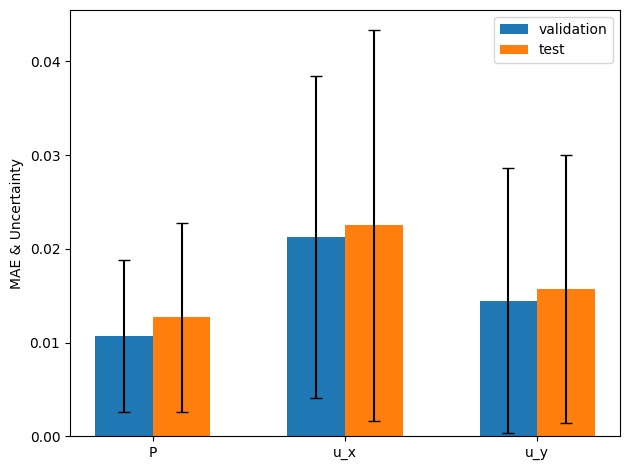

In [ ]:
# plot per channel MAE with uncertainty
val_loss_c, test_loss_c = [], []
for channel in range(3):
  val_loss_c.append( tf.reduce_mean(mae(preds_mean[...,channel], y_val[...,channel])) )
  test_loss_c.append( tf.reduce_mean(mae(preds_test_mean[...,channel], y_test[...,channel])) )

fig, ax = plt.subplots()
ind = np.arange(len(val_loss_c)); width=0.3
bars1 = ax.bar(ind - width/2, val_loss_c, width, yerr=uncertainty_total, capsize=4, label="validation")
bars2 = ax.bar(ind + width/2, test_loss_c, width, yerr=uncertainty_test_total, capsize=4, label="test")
ax.set_ylabel("MAE & Uncertainty")
ax.set_xticks(ind); ax.set_xticklabels(('P', 'u_x', 'u_y'))
ax.legend(); plt.tight_layout()

[CHECKThe mean error is clearly larger, and the slightly larger uncertainties of the predictions are likewise visible via the error bars.

In general it is hard to obtain a calibrated uncertainty estimate, but since we are dealing with a fairly simple problem here, the BNN is able to estimate the uncertainty reasonably well.

The next graph shows the differences of the ENSAMBLE predictions for a single case of the test set (using the same style as for the validation sample above)}:

num_preds was set to 5, but has to be smaller than the length of preds. Setting it to 3


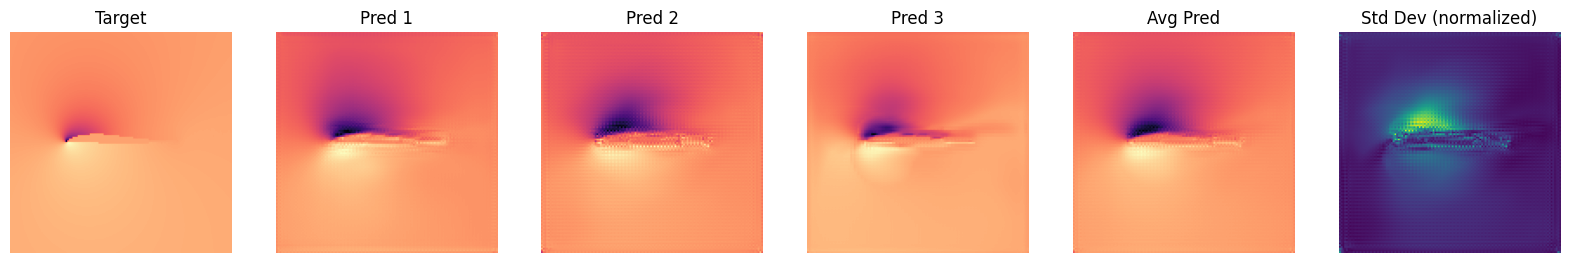

In [ ]:
OBS_IDX=5
plot_BNN_predictions(y_test[OBS_IDX,...],preds_test[:,OBS_IDX,:,:,:],preds_test_mean[OBS_IDX,...],preds_test_std[OBS_IDX,...])

We can also visualize several shapes from the test set together with the corresponding marginalized prediction and uncertainty.

Text(0.5, 1.0, 'Std. Dev')

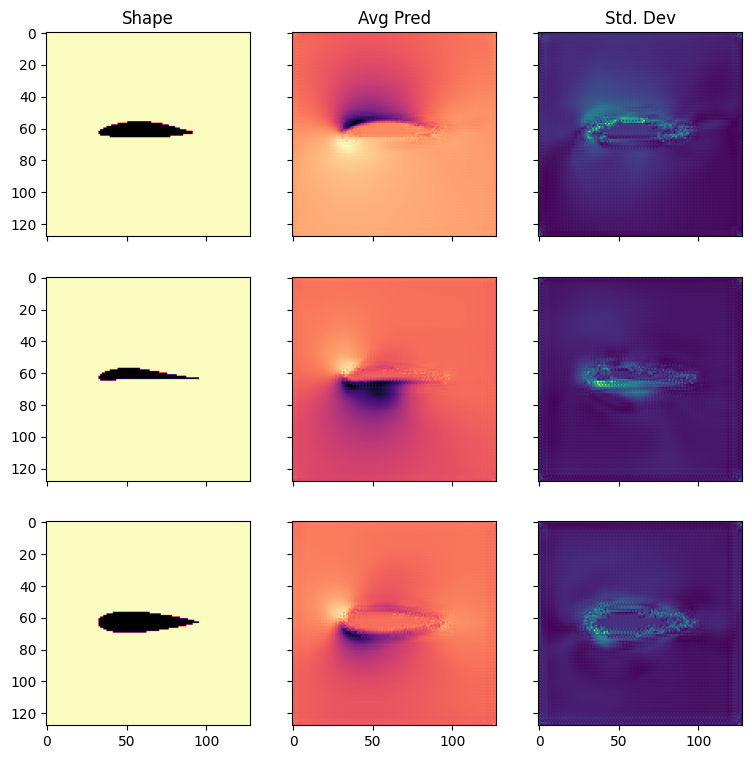

In [ ]:
IDXS = [1,3,8]
CHANNEL = 0
fig, axs = plt.subplots(nrows=len(IDXS),ncols=3,sharex=True, sharey = True, figsize = (9,len(IDXS)*3))
for i, idx in enumerate(IDXS):
  axs[i][0].imshow(np.flipud(X_test[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][1].imshow(np.flipud(preds_test_mean[idx,:,:,CHANNEL].transpose()), cmap=cm.magma)
  axs[i][2].imshow(np.flipud(preds_test_std[idx,:,:,CHANNEL].transpose()), cmap=cm.viridis)
axs[0][0].set_title('Shape')
axs[0][1].set_title('Avg Pred')
axs[0][2].set_title('Std. Dev')


As we can see, the shapes from the test set differ quite a bit from another. Nevertheless, the uncertainty estimate is reasonably distributed. It is especially high in the boundary layer around the airfoil, and in the regions of the low pressure pocket.

## Next steps

[ADD EVIDENTIAL AND MIMO]